<a href="https://colab.research.google.com/github/pauldebayan/SpectaGen/blob/main/SpectaGen.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# from google.colab import files
# uploaded = files.upload()


In [3]:
!wget https://raw.githubusercontent.com/pauldebayan/SpectaGen/refs/heads/main/labels.csv
!wget https://github.com/pauldebayan/SpectaGen/raw/refs/heads/main/spectacle_dataset.zip
!unzip spectacle_dataset.zip

--2024-10-08 08:26:28--  https://raw.githubusercontent.com/pauldebayan/SpectaGen/refs/heads/main/labels.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 15893 (16K) [text/plain]
Saving to: ‘labels.csv’

labels.csv          100%[===================>]  15.52K  --.-KB/s    in 0s      

2024-10-08 08:26:28 (33.6 MB/s) - ‘labels.csv’ saved [15893/15893]

--2024-10-08 08:26:28--  https://github.com/pauldebayan/SpectaGen/raw/refs/heads/main/spectacle_dataset.zip
Resolving github.com (github.com)... 140.82.114.4
Connecting to github.com (github.com)|140.82.114.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/pauldebayan/SpectaGen/refs/heads/main/spectacle_dataset.zip [following]
--2024-10-08 08:26:

In [4]:
!ls

labels.csv  sample_data  spectacle_dataset  spectacle_dataset.zip


In [5]:
from torchvision.io import read_image
import matplotlib.pyplot as plt
import torchvision
import torch
from torch import nn
import os
import pandas as pd
import torchvision.transforms as transforms
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torch.nn as nn

In [6]:
def ImagesToDelete():
    # To check all the images is of same shape
    channel, height, width = 3, 512, 512

    imagesToDelete = []

    for i in range(1, 1000):
        img = read_image(f'./spectacle_dataset/specs{(i+1)}.jpg')

        if(img.shape[0] != channel or img.shape[1] != height or img.shape[2] != width):
            imagesToDelete.append(f'specs{(i+1)}.jpg')

    # We need to delete this images as they do not have the desired shape - [3, 256, 512]
    return imagesToDelete

print(ImagesToDelete())


[]


In [7]:
# Check if GPU is available and move model to GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print(device)

cpu


In [12]:
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()

        self.conv1 = nn.Conv2d(3, 20, 2)
        self.conv2 = nn.Conv2d(20, 10, 2)
        self.conv3 = nn.Conv2d(10, 10, 2)

        self.activ = nn.LeakyReLU()
        self.pool = nn.MaxPool2d(2, 2)
        self.dropout = nn.Dropout(0.25)

        self.linear_stack = nn.Sequential(
            nn.Linear(39690, 2000),
            nn.LeakyReLU(),
            nn.Linear(2000,800),
            nn.LeakyReLU(),
            nn.Linear(800,400),
            nn.LeakyReLU(),
            nn.Linear(400, 1),
            nn.Sigmoid()
        )

    def forward(self, x):

        x = self.pool(self.activ(self.conv1(x)))
        x = self.pool(self.activ(self.conv2(x)))
        x = self.pool(self.activ(self.conv3(x)))
        x = self.dropout(x)

        x = x.view(x.size(0), -1)
        x = self.linear_stack(x)
        return x

        #return x.shape



In [13]:
class Genearator(nn.Module):

    def __init__(self):
        super().__init__()

        self.gen_sequence = nn.Sequential(
            nn.ConvTranspose2d(8, 512, 6, stride=2),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(),

            nn.ConvTranspose2d(512, 256, 4, stride=3),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(),

            nn.ConvTranspose2d(256, 128, 6, stride=2),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(),

            nn.ConvTranspose2d(128, 64, 5, stride=2),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(),

            nn.ConvTranspose2d(64, 3, 4, stride=2),
            nn.Tanh()
        )


    def forward(self, x):
        x = x.view(-1, 8, 8, 8)  # [batch_size, channels, height, width]
        x = self.gen_sequence(x)
        return x


In [14]:
generator = Genearator()
generator = generator.to(device)
discriminator = Discriminator()
discriminator = discriminator.to(device)

print(discriminator)
print(generator)

Discriminator(
  (conv1): Conv2d(3, 20, kernel_size=(2, 2), stride=(1, 1))
  (conv2): Conv2d(20, 10, kernel_size=(2, 2), stride=(1, 1))
  (conv3): Conv2d(10, 10, kernel_size=(2, 2), stride=(1, 1))
  (activ): LeakyReLU(negative_slope=0.01)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout): Dropout(p=0.25, inplace=False)
  (linear_stack): Sequential(
    (0): Linear(in_features=39690, out_features=2000, bias=True)
    (1): LeakyReLU(negative_slope=0.01)
    (2): Linear(in_features=2000, out_features=800, bias=True)
    (3): LeakyReLU(negative_slope=0.01)
    (4): Linear(in_features=800, out_features=400, bias=True)
    (5): LeakyReLU(negative_slope=0.01)
    (6): Linear(in_features=400, out_features=1, bias=True)
    (7): Sigmoid()
  )
)
Genearator(
  (gen_sequence): Sequential(
    (0): ConvTranspose2d(8, 512, kernel_size=(6, 6), stride=(2, 2))
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2)

In [16]:
# To get the input of the linear layer in Discriminator

img = read_image('./spectacle_dataset/specs1.jpg')
print(img.shape)
print(discriminator(img.float()))
#39690
#Will cause error because of batch size

torch.Size([3, 512, 512])


RuntimeError: mat1 and mat2 shapes cannot be multiplied (10x3969 and 39690x2000)

In [17]:
def generateNoise():
    noise = torch.randn(1, 512)
    return noise

# Conv2d: (N-K+1)/S
# ConvTranspose2d: (N-1)*S+K

torch.Size([1, 3, 512, 512])
Fake image shape: torch.Size([1, 3, 512, 512])


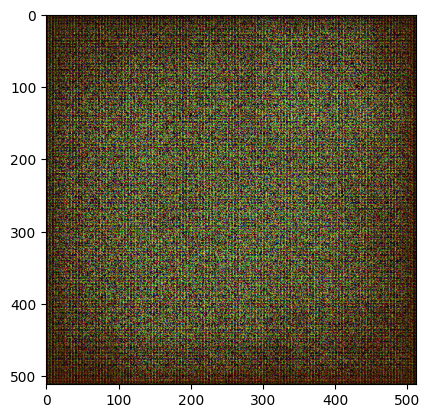

In [18]:
noise = generateNoise()
noise = noise.to(device)
img = generator(noise)

img = img.to(device)

print(img.shape)
plt.imshow(img.cpu().squeeze().detach().permute(1, 2, 0))

print(f"Fake image shape: {img.shape}")


In [19]:
# Real Images - set dataloader
class SpectDataset(Dataset):
    def __init__(self, annotations_file, img_dir, transform=None, target_transform=None):
        self.img_labels = pd.read_csv(annotations_file)
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0])
        image = read_image(img_path)
        label = self.img_labels.iloc[idx, 1]
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)

        return image, label


In [20]:
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.ToTensor()
])

dataset = SpectDataset(img_dir = 'spectacle_dataset',
                             annotations_file = 'labels.csv',
                             transform = transform)

batch_size = 6
dl = DataLoader(dataset, batch_size=batch_size, shuffle=True)

In [21]:
epochs = 10000000
lr = 0.0001

In [22]:
loss_fn = nn.BCELoss()
optimizer_G = torch.optim.Adam(generator.parameters(), lr=lr)
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=lr)

In [ ]:
# Implementing GANs

for epoch in range(epochs):



    batch_counter = 1
    for real_img, real_label in dl:

        real_img = real_img.to(device)
        real_label = torch.tensor(1).float().to(device)

        noise = generateNoise().to(device)
        fake_img = generator(noise).to(device)
        fake_label = torch.tensor(0).float().to(device)


        #Generator
        optimizer_G.zero_grad()
        loss_G = loss_fn(discriminator(fake_img).squeeze(), real_label)
        loss_G.backward()
        optimizer_G.step()


        #Discriminator
        optimizer_D.zero_grad()
        fake_loss = loss_fn(discriminator(fake_img.detach()).squeeze(), fake_label)
        real_loss = loss_fn(discriminator(real_img).mean().squeeze(), real_label)
        loss_D = (fake_loss+real_loss)/2
        loss_D.backward()
        optimizer_D.step()

        gen_loss = loss_G.item()
        dis_loss = loss_D.item()

        print(f"Epoch{epoch+1} Batch{batch_counter}: Discriminator Loss: {dis_loss}, Generator Loss: {gen_loss}")
        batch_counter += 1


    if ((epoch+1)%10) == 0:
        noise = generateNoise()
        noise = noise.to(device)
        fake_img = generator(noise)
        fake_img = fake_img.to(device)
        torchvision.utils.save_image(fake_img, 'generated.jpg')
        plt.imshow(fake_img.cpu().squeeze().detach().permute(1, 2, 0))
        plt.show()
        torch.save(generator.state_dict(), 'model.pt')
        #playsound('epoch10.mp3')

    if gen_loss > 100:
        break




Epoch1 Batch1: Discriminator Loss: 0.6934462785720825, Generator Loss: 0.7048908472061157
Epoch1 Batch2: Discriminator Loss: 0.6799939870834351, Generator Loss: 0.7128915786743164
Epoch1 Batch3: Discriminator Loss: 0.6531511545181274, Generator Loss: 0.7543149590492249
